# EYE FOR BLIND 
- **This capstone is developed by `SWARNAVA BHATTACHARJEE`(DS C-36) under Upgrad-IIITB EPGPDS(DL track)**
- This project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.
    - Paper link : https://arxiv.org/abs/1502.03044
- Dataset link: https://www.kaggle.com/datasets/adityajn105/flickr8k
- Original Code link : https://www.kaggle.com/code/swarnava007/eye-for-blind-capstone-dl

## Data Description:
- The dataset is taken from the Kaggle website and it consists of `sentence-based image descriptions` having a list of `8,000 images` that are each paired with `five different captions` which provide clear descriptions of the salient entities and events of the image.

## Project mind map/approach:
1. `Data Understanding`: Here, you need to load the data and understand the representation.
2. `Data Preprocessing`: In this step, you will process both images and captions to the desired format.
3. `Train-Test Split`: Combine both images and captions to create the train and test dataset.
4. `Model Building`: This is the stage where you will create your image captioning model by building Encoder, Attention and Decoder model.
5. `Model Evaluation`: Evaluate the models using greedy search and BLEU score.

### Importing nessesary libraries:

In [1]:
#Import all the required libraries

import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", color_codes=True)


In [2]:
#tensorflow and keras version used
print(tf.__version__ ,
keras.__version__)

2.6.4 2.6.0


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='../input/flickr8k/Images' #this code is developed in latest kaggle environment

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
# ../input/flickr8k/captions.txt
caption_df = pd.read_csv("../input/flickr8k/captions.txt", sep=",") #making caption dataframe
caption_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


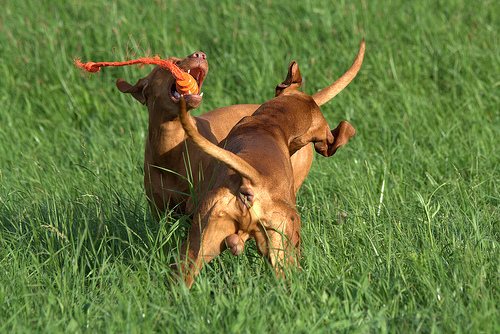

In [5]:
#Visualise both the images & text present in the dataset
img = all_imgs[7]
Image.open(img)

In [6]:
# captions for previous image
#text and caption for the image
idx = img.split('/')[-1]
print(f'Image name: {idx}\n')
print(f'Image path: {img}\n')
row = caption_df.index[caption_df['image'] == idx].tolist()

start,end = row[0],row[len(row)-1]
print('Image caption: \n')
print(caption_df.iloc[start:end+1].caption)

Image name: 1206506157_c7956accd5.jpg

Image path: ../input/flickr8k/Images/1206506157_c7956accd5.jpg

Image caption: 

865                       Dogs fight in grass over toy .
866    On grass , two brown dogs tussle for orange toy .
867    Two dogs are playing rough in a green field of...
868     Two dogs play with an orange toy in tall grass .
869      Two large brown dogs are playing in the grass .
Name: caption, dtype: object


In [7]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    text = open(filename).read()
    
    return text

text_file = '../input/flickr8k/captions.txt'
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
#creating merged dataframe with ID path and captions
all_img_id= caption_df.image
all_img_vector= '../input/flickr8k/Images/'+ all_img_id
annotations= caption_df.caption

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()


,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,../input/flickr8k/Images/1000268201_693b08cb0e...,A little girl in a pink dress going into a woo...


In [9]:
print(f'Total samples in dataset : {len(annotations)}') #total number of samples in dataset

Total samples in dataset : 40455


In [10]:
#Create the vocabulary & the counter for the captions

vocabulary= [word.lower() for line in annotations for word in line.split()] 

val_count=Counter(vocabulary)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 

{'a': 62986, '.': 36577, 'in': 18974, 'the': 18418, 'on': 10743, 'is': 9345, 'and': 8851, 'dog': 8136, 'with': 7765, 'man': 7265, 'of': 6713, 'two': 5638, 'white': 3940, 'black': 3832, 'boy': 3581, 'are': 3504, 'woman': 3402, 'girl': 3328, ',': 3232, 'to': 3173, 'wearing': 3062, 'at': 2914, 'people': 2883, 'water': 2783, 'red': 2672, 'young': 2630, 'brown': 2563, 'an': 2432, 'his': 2357, 'blue': 2268}


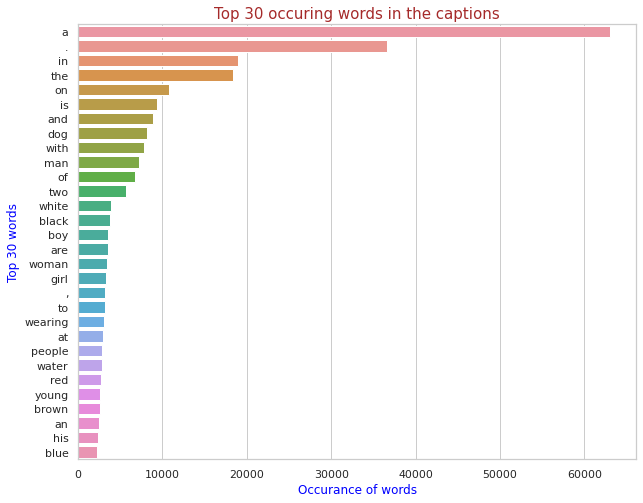

In [11]:
#Visualise the top 30 occuring words in the captions
def top_n(counter,n):
    top_n = counter.most_common(n)
    x,y = [], []
    for i,j in enumerate(top_n):
        x.append(j[0])
        y.append(j[1])
    print(dict(zip(x,y))) #printing top n most ocurring words

    plt.figure(figsize=[10,8])
    sns.barplot(y,x, orient='h')
    plt.xlabel('Occurance of words',color='blue')
    plt.ylabel(f'Top {n} words',color='blue')
    plt.title(f'Top {n} occuring words in the captions',size=15, color='brown')
    plt.show()
    
top_n(val_count,30)

### Observation:
- most of the occuring words are STOPWORDS and we need preprocess them for better model training and visualization

In [12]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations=df.Captions.apply(lambda line:"<start>"+" "+line+" "+"<end>").tolist()

#Create a list which contains all the path to the images
all_img_path=df.Path.tolist()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
annotations[:5] #varifying captions with start and end tokens

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the token
top_vocab = 5000 #keeping top 5000 words for saving memory
token  = tf.keras.preprocessing.text.Tokenizer(num_words=top_vocab,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',lower=True,split=' ',char_level=False,oov_token='UNK')


In [15]:
# Create word-to-index and index-to-word mappings.
token.fit_on_texts(annotations)
train_seq = token.texts_to_sequences(annotations)
# we will be using 0 as the padding value. As 0 is a reserved index,
# keras use different index for UNKNOWN.
token.word_index['PAD'] = 0
token.index_word[0] = 'PAD'
train_seq = token.texts_to_sequences(annotations)

{'a': 62992, '<start>': 40455, '<end>': 40455, 'in': 18986, 'the': 18419, 'on': 10745, 'is': 9345, 'and': 8862, 'dog': 8138, 'with': 7765, 'man': 7274, 'of': 6723, 'two': 5642, 'white': 3959, 'black': 3848, 'boy': 3581, 'are': 3504, 'woman': 3402, 'girl': 3328, 'to': 3176, 'wearing': 3062, 'at': 2915, 'people': 2883, 'water': 2790, 'red': 2691, 'young': 2630, 'brown': 2578, 'an': 2432, 'his': 2357, 'blue': 2279}


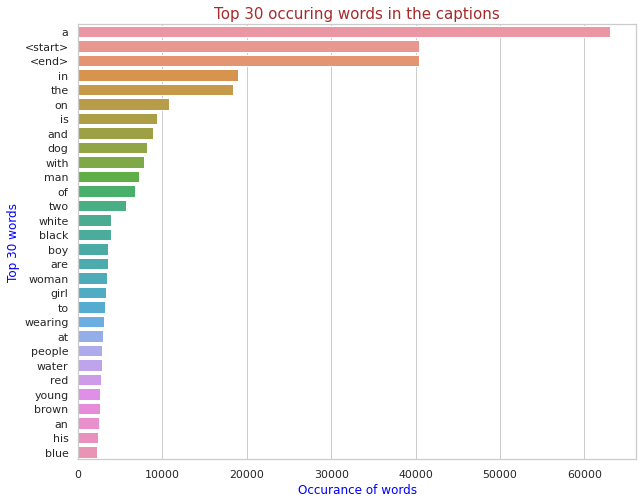

In [16]:
# Create a word count of your token to visulize the Top 30 occuring words after text processing
prep_counter = Counter(token.word_counts)
#your code here
top_n(prep_counter,30)#after preprocessing of captions

In [17]:
train_seq[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [18]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_len = max([len(cap) for cap in train_seq]) #maximum length of captions
print(f'Max sequence length: {max_len}')
cap_vector=  tf.keras.preprocessing.sequence.pad_sequences(train_seq, padding='post',maxlen=max_len,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

Max sequence length: 39
The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [19]:
#write your code here to create the dataset consisting of image paths
img_size = (299,299) #image size(299*299)


In [20]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) # channels = 0 for same as imput image channel and channel =3 for RGB inputs
    image = tf.image.resize(image, size=img_size)
    image = tf.keras.applications.inception_v3.preprocess_input(image) #normalize the image values between -1 & 1
    
    return image,image_path

Path before preprocessing: ../input/flickr8k/Images/1002674143_1b742ab4b8.jpg


2022-10-17 17:44:59.592625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:44:59.686433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:44:59.687236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:44:59.691250: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Shape after  preprocessing : (299, 299, 3)
Path after preprocessing : ../input/flickr8k/Images/1002674143_1b742ab4b8.jpg


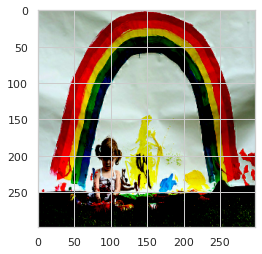

In [21]:
#checking a sample image before batch conversion
print("Path before preprocessing:",(all_img_vector[13]))
print("Shape after  preprocessing :", load_image(all_img_vector[13])[0].shape)
print('Path after preprocessing :',load_image(all_img_vector[13])[1] )
plt.imshow(load_image(all_img_vector[13])[0])
warnings.filterwarnings("ignore")

In [22]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
print(f'All image vector contains {len(all_img_vector)} images')
# unique image vector paths
all_unique_img_vector = sorted(set(all_img_vector))
print( 'no of unique vector path is :', len(all_unique_img_vector))
# transforming into tf dataset
image_path_tfd = tf.data.Dataset.from_tensor_slices(all_unique_img_vector)
#mapping the preprocessing image function with batch of 32
#optimizing with tf.data.experimental.AUTOTUNE
image_path_tfd = image_path_tfd.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32,drop_remainder=False)
print(image_path_tfd)

All image vector contains 40455 images
no of unique vector path is : 8091
<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [23]:
#loading pre-trained InceptionV3 model 
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input # the input of the image_model
hidden_layer = image_model.layers[-1].output  #the output of the image_model

image_features_extract_model =  keras.Model(new_input, hidden_layer)#the final model using both input & output layer

87924736/87910968 [==============================] - 0s 0us/step


In [24]:
image_features_extract_model.summary() #model architecture

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

- We need to extract feature vector for our images. So we are removing the softmax layer from the model.

In [25]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
warnings.filterwarnings("ignore")
features_dict={} #creating dict to store features
for image, image_path in tqdm(image_path_tfd): #using tqdm to show progress bar
    #feeding images from above created dataset to Inception v3 which we build above
    features_batch = image_features_extract_model(image) 
    features_batch = tf.reshape(features_batch,(features_batch.shape[0], -1, features_batch.shape[3])) #reshaping feature vector
                                   
    for feature_b, path in zip(features_batch, image_path):
        feature_path = path.numpy().decode("utf-8")
        features_dict[feature_path] =  feature_b.numpy()


  0%|          | 0/253 [00:00<?, ?it/s]2022-10-17 17:45:05.502221: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-17 17:45:06.635210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 253/253 [00:59<00:00,  4.28it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [26]:
#splitting dataset in train test sets(80%-20% split) with random state=42

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,train_size=0.8,random_state=42)

In [27]:
#samples in splitted datasets
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [28]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image, caption):
  img_tensor = features_dict[image.decode('utf-8')]
  return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [29]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
batch_size = 32
buffer = 1000
def gen_dataset(image_path, caption):
    
    #create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption))
    dataset = dataset.shuffle(buffer,reshuffle_each_iteration=True)
    
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE) #parallelizing the process
    
    return dataset



In [30]:
#train and test dataset conversions
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [31]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [32]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // batch_size
test_num_steps = len(path_test) // batch_size

### Encoder

In [33]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim) #build your Dense layer with relu activation
#         self.dropout = tf.keras.layers.Dropout(0.5)
    def call(self, features):
        features =  self.fc(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [34]:
encoder=Encoder(embedding_dim)

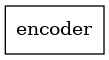

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

### Attention model

In [36]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units) #build your Dense layer
        self.W2 = layers.Dense(units) #build your Dense layer
        self.V = layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

- The attention model does a linear transformation of the input.So we are applying tanh function on top of it.

- Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

- At last step we derived our context vector.

- This context vector change for each and every time stamp.

### Decoder

In [37]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim, mask_zero=False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build your Dense layer
        self.d2 = layers.Dense(vocab_size) #build your Dense layer
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
#         embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(context_vector,1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
#         print(output.shape)
        output = tf.reshape(output,(-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
#         print(output.shape)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
#         print(output.shape)
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
decoder=Decoder(embedding_dim, units, vocab_size)

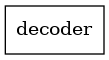

In [39]:
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)

In [40]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([token.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [41]:
optimizer = tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [42]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [43]:
checkpoint_path = "flickr8k/checkpoint/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #code to do the training steps
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [46]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))  
    return loss, avg_loss

In [47]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [48]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    #train loss
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss) #test loss
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.182, & test loss is 1.003
Time taken for 1 epoch 234.28720927238464 sec

Test loss has been reduced from 100.000 to 1.003


 13%|█▎        | 2/15 [05:49<35:38, 164.48s/it]

For epoch: 2, the train loss is 0.930, & test loss is 0.891
Time taken for 1 epoch 115.26365232467651 sec

Test loss has been reduced from 1.003 to 0.891


 20%|██        | 3/15 [07:45<28:24, 142.08s/it]

For epoch: 3, the train loss is 0.848, & test loss is 0.823
Time taken for 1 epoch 115.23282933235168 sec

Test loss has been reduced from 0.891 to 0.823


 27%|██▋       | 4/15 [09:40<24:07, 131.61s/it]

For epoch: 4, the train loss is 0.790, & test loss is 0.771
Time taken for 1 epoch 115.38529300689697 sec

Test loss has been reduced from 0.823 to 0.771


 33%|███▎      | 5/15 [11:36<20:57, 125.78s/it]

For epoch: 5, the train loss is 0.742, & test loss is 0.725
Time taken for 1 epoch 115.24996256828308 sec

Test loss has been reduced from 0.771 to 0.725


 40%|████      | 6/15 [13:31<18:20, 122.28s/it]

For epoch: 6, the train loss is 0.699, & test loss is 0.686
Time taken for 1 epoch 115.2992856502533 sec

Test loss has been reduced from 0.725 to 0.686


 47%|████▋     | 7/15 [15:27<15:59, 119.96s/it]

For epoch: 7, the train loss is 0.660, & test loss is 0.648
Time taken for 1 epoch 115.00485706329346 sec

Test loss has been reduced from 0.686 to 0.648
For epoch: 8, the train loss is 0.625, & test loss is 0.615
Time taken for 1 epoch 115.19576239585876 sec

Test loss has been reduced from 0.648 to 0.615


 60%|██████    | 9/15 [19:17<11:44, 117.45s/it]

For epoch: 9, the train loss is 0.592, & test loss is 0.582
Time taken for 1 epoch 114.89660549163818 sec

Test loss has been reduced from 0.615 to 0.582


 67%|██████▋   | 10/15 [21:12<09:44, 116.81s/it]

For epoch: 10, the train loss is 0.562, & test loss is 0.553
Time taken for 1 epoch 115.21156334877014 sec

Test loss has been reduced from 0.582 to 0.553


 73%|███████▎  | 11/15 [23:08<07:45, 116.28s/it]

For epoch: 11, the train loss is 0.536, & test loss is 0.526
Time taken for 1 epoch 114.87729454040527 sec

Test loss has been reduced from 0.553 to 0.526


 80%|████████  | 12/15 [25:03<05:47, 115.93s/it]

For epoch: 12, the train loss is 0.510, & test loss is 0.502
Time taken for 1 epoch 114.96085715293884 sec

Test loss has been reduced from 0.526 to 0.502


 87%|████████▋ | 13/15 [26:58<03:51, 115.67s/it]

For epoch: 13, the train loss is 0.488, & test loss is 0.481
Time taken for 1 epoch 114.88442015647888 sec

Test loss has been reduced from 0.502 to 0.481


 93%|█████████▎| 14/15 [28:53<01:55, 115.44s/it]

For epoch: 14, the train loss is 0.468, & test loss is 0.459
Time taken for 1 epoch 114.73545098304749 sec

Test loss has been reduced from 0.481 to 0.459


100%|██████████| 15/15 [30:48<00:00, 123.23s/it]

For epoch: 15, the train loss is 0.449, & test loss is 0.440
Time taken for 1 epoch 115.03704333305359 sec

Test loss has been reduced from 0.459 to 0.440


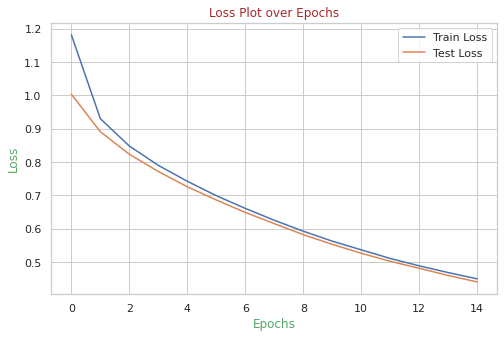

In [49]:
plt.figure(figsize=(8,5))
plt.plot(loss_plot, label='Train Loss')
plt.plot(test_loss_plot, label='Test Loss')
plt.xlabel('Epochs',color='g')
plt.ylabel('Loss',color='g')
plt.title('Loss Plot over Epochs',color='brown')
plt.legend()
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [50]:
def evaluate(image):
    max_length = max_len
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) #Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) #extract the features by passing the input to encoder

    dec_input = tf.expand_dims([token.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) #get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        #extract the predicted id(embedded value) which carries the max value
        result.append(token.index_word[predicted_id])
        #map the id to the word from token and append the value to the result list

        if token.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [51]:
def beam_evaluate(image, beam_index = 3):

    max_length=max_len
    start = [token.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([token.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [token.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
                  
    return final_caption



In [52]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [53]:
from nltk.translate.bleu_score import sentence_bleu

In [54]:
def filt_text(text):
    filt=['<start>','UNK','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [55]:
features_shape = feature_b.shape[1]
attention_features_shape = feature_b.shape[0]

BELU score: 78.81929718099911
Real Caption: a white dog is jumping up out of the water to catch a ball
Prediction Caption: a white dog is jumping out of the water to catch a ball


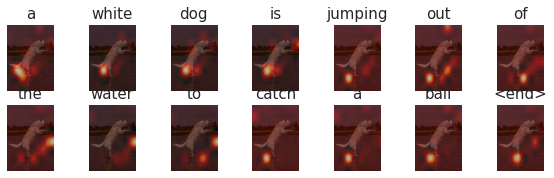

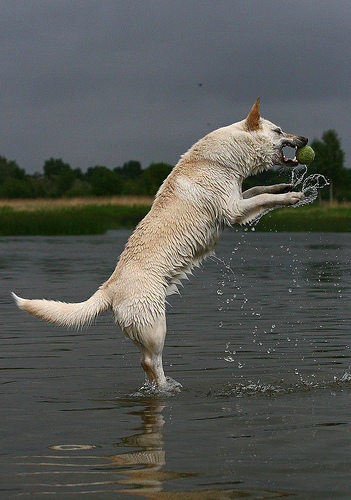

In [56]:
rid = np.random.randint(0, len(path_test))
test_image = path_test.reset_index(drop=True)[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([token.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [57]:
captions=beam_evaluate(test_image)
print(captions) #beam search caption
print(pred_caption) #greedy search caption

the white dog jumps jumping out of water
a white dog is jumping out of the water to catch a ball


## Text to Speech conversion
- through Google text to speech api

In [58]:
! pip install gTTS

In [60]:
# Import the required module for text to speech conversion
from gtts import gTTS
import IPython
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file 
myobj.save("Predicted_speech.mp3")
  
# Playing the converted file
audio_file  = "./Predicted_speech.mp3"
IPython.display.display(IPython.display.Audio(audio_file)) #displaying audio output

## Conclusion: 

In this capstone project, we created a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. 

This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.

The decoder (RNN -here GRU) attends over the image to predict the next word. We used the attention model to make our decoder focus on a particular part of the image at a time rather than focusing on the entire image.The decoder returns the predicted caption and the decoder's hidden state as output. which is sent back to the model and the predictions are used to calculate the loss using cross-entropy "SparseCategoricalCrossentropy".We also used teacher forcing to decide the next input to the decoder.

The decoder stop predicting when the model predicts the end token.

The prediction of the words by the model is done by finding out the probabilities of that word in the vocabulary. We are using the greedy search method. It calculates the probability of the words according to their occurrence in the vocabulary. It takes the sample of the words, finds the probability of each word, and then outputs the word with the highest probability.

Finally, we are using the "BLEU score"(Bilingual Evaluation Understudy) as the evaluation metric for the predicted word. It determines the difference between the predicted caption and the real caption.